In this notebook we will be implementing Karpathy's makemore lecture 3, in which we will be investigating activations, gradients and the batchnorm layer.

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# read in the sequences of demand profiles
data = open('../data/data.txt','r').read().splitlines()
data[:8]

['<M> <M> <M> <M> <M> <M> <M> <M> <M> <M> 1.0 2.0 4.0 4.0 4.0 1.0 1.0 1.0 1.0 2.0 1.0 2.0 1.0 1.0',
 '1.0 1.0 1.0 1.0 1.0 1.0 2.0 3.0 1.0 1.0 1.0 1.0 1.0 2.0 7.0 4.0 4.0 2.0 1.0 2.0 1.0 1.0 1.0 1.0',
 '1.0 1.0 1.0 1.0 1.0 2.0 1.0 3.0 6.0 1.0 1.0 1.0 1.0 1.0 1.0 4.0 8.0 2.0 2.0 2.0 2.0 1.0 1.0 1.0',
 '1.0 1.0 1.0 1.0 1.0 1.0 3.0 1.0 1.0 2.0 1.0 1.0 1.0 1.0 4.0 1.0 7.0 2.0 1.0 1.0 1.0 1.0 1.0 1.0',
 '1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0',
 '1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0',
 '1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0 1.0 0.0 0.0 0.0',
 '1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0 0.0 1.0 0.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0']

In [4]:
# now we want to create the mapping from string to indices
chars = []
chars.append('<S>') # start token
# Define your order
order = ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0', '12.0', '13.0', '14.0', '15.0', '16.0', '17.0', '18.0', '19.0', '20.0']
for i in order:
    chars.append(i)
chars.append('<M>') #<- missing token
chars.append('<E>') # end token
stoi = {s:i for i,s in enumerate(chars)}
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
itos

{0: '<S>',
 1: '0.0',
 2: '1.0',
 3: '2.0',
 4: '3.0',
 5: '4.0',
 6: '5.0',
 7: '6.0',
 8: '7.0',
 9: '8.0',
 10: '9.0',
 11: '10.0',
 12: '11.0',
 13: '12.0',
 14: '13.0',
 15: '14.0',
 16: '15.0',
 17: '16.0',
 18: '17.0',
 19: '18.0',
 20: '19.0',
 21: '20.0',
 22: '<M>',
 23: '<E>'}

In [5]:
# let's put this all together
block_size = 3 # this is the context length aka the number of characters we used to predict the next in sequence
# let's create the training, dev and test sets
def build_dataset(data):
    X, Y = [], []
    for s in data:
        #print(s)
        context = [0] * block_size
        for ch in s.split(' ') + ['<E>']:
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(' '.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(data)
n1 = int(0.8 * len(data))
n2 = int(0.9 * len(data))
Xtr, Ytr = build_dataset(data[:n1])
Xdev, Ydev = build_dataset(data[n1:n2])
Xte, Yte = build_dataset(data[n2:])



torch.Size([13475, 3]) torch.Size([13475])
torch.Size([1675, 3]) torch.Size([1675])
torch.Size([1700, 3]) torch.Size([1700])


In [69]:
# MLP
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),               generator=g) # the character embedding matrix
W1 = torch.randn((n_embd * block_size, n_hidden),   generator=g) * (5/3) / (n_embd * block_size)**0.5 # the input weights
#b1 = torch.randn((n_hidden,),                       generator=g) * 0.001 # the input biases
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.01 # the output weights
b2 = torch.randn((vocab_size,),                     generator=g) * 0 # the output biases

# BatchNorm layer
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11664


In [70]:
# same optimisation as mlp
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # construct a mini-batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # 32 x 3 x 10
    embcat = emb.view(emb.shape[0], -1) # 32 x 30
    hpreact = embcat @ W1 #+ b1 # 32 x 30 @ 30 x 200 + 200 -> 32 x 200
    # BatchNorm layer
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / (bnstdi + 1e-5) - bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    # non-linearity
    h = torch.tanh(hpreact) # hidden layer, 32 x 200
    logits = h @ W2 + b2 # 32 x 200 @ 200 x 24 + 24 -> 32 x 24
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    #
    # track stats
    if i % 10000 == 0: 
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    # break


      0/ 200000: 3.1875
  10000/ 200000: 1.0726
  20000/ 200000: 1.0800
  30000/ 200000: 1.2663
  40000/ 200000: 1.1544
  50000/ 200000: 1.3154
  60000/ 200000: 1.1077
  70000/ 200000: 0.9671
  80000/ 200000: 1.1689
  90000/ 200000: 0.8855
 100000/ 200000: 0.9109
 110000/ 200000: 1.2118
 120000/ 200000: 0.9339
 130000/ 200000: 1.1193
 140000/ 200000: 1.0278
 150000/ 200000: 1.0741
 160000/ 200000: 0.9362
 170000/ 200000: 0.9886
 180000/ 200000: 0.8914
 190000/ 200000: 1.2782


(array([427., 210., 206., 207., 140., 185., 126.,  99., 109.,  95., 123.,
        121.,  71.,  77.,  68.,  87.,  77.,  80.,  86.,  98.,  79.,  98.,
         75.,  68.,  61., 135.,  64.,  80.,  58., 116.,  64.,  65.,  91.,
        127.,  91., 116., 125.,  99.,  92., 100.,  98.,  88., 148., 107.,
        122., 210., 235., 164., 363., 369.]),
 array([-9.99749899e-01, -9.59755936e-01, -9.19761972e-01, -8.79768009e-01,
        -8.39774046e-01, -7.99780083e-01, -7.59786119e-01, -7.19792156e-01,
        -6.79798193e-01, -6.39804230e-01, -5.99810266e-01, -5.59816303e-01,
        -5.19822340e-01, -4.79828377e-01, -4.39834414e-01, -3.99840450e-01,
        -3.59846487e-01, -3.19852524e-01, -2.79858561e-01, -2.39864597e-01,
        -1.99870634e-01, -1.59876671e-01, -1.19882708e-01, -7.98887444e-02,
        -3.98947811e-02,  9.91821289e-05,  4.00931454e-02,  8.00871086e-02,
         1.20081072e-01,  1.60075035e-01,  2.00068998e-01,  2.40062962e-01,
         2.80056925e-01,  3.20050888e-01,  3.60044

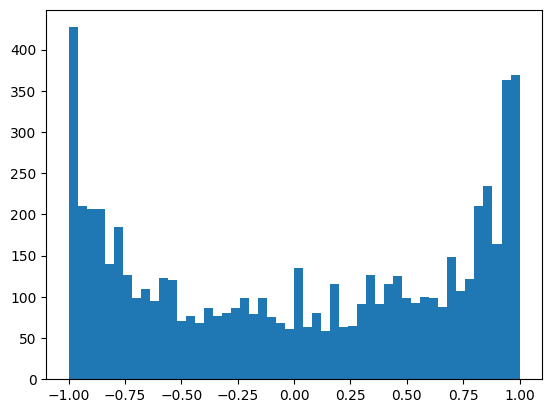

In [50]:
plt.hist(h.view(-1).tolist(), bins=50)

(array([  3.,   0.,   0.,   1.,   0.,   4.,  20.,  75.,  55.,  48.,  82.,
         38., 100., 123., 121., 181., 247., 316., 264., 362., 278., 382.,
        390., 406., 400., 429., 292., 267., 314., 301., 155., 205., 188.,
        108.,  40.,  43.,  64.,  12.,  16.,  23.,   9.,   5.,   0.,  14.,
          4.,  13.,   0.,   0.,   1.,   1.]),
 array([-4.49335432e+00, -4.29786050e+00, -4.10236668e+00, -3.90687285e+00,
        -3.71137903e+00, -3.51588521e+00, -3.32039139e+00, -3.12489757e+00,
        -2.92940374e+00, -2.73390992e+00, -2.53841610e+00, -2.34292228e+00,
        -2.14742846e+00, -1.95193463e+00, -1.75644081e+00, -1.56094699e+00,
        -1.36545317e+00, -1.16995934e+00, -9.74465523e-01, -7.78971701e-01,
        -5.83477879e-01, -3.87984056e-01, -1.92490234e-01,  3.00358772e-03,
         1.98497410e-01,  3.93991232e-01,  5.89485054e-01,  7.84978876e-01,
         9.80472698e-01,  1.17596652e+00,  1.37146034e+00,  1.56695416e+00,
         1.76244799e+00,  1.95794181e+00,  2.15343

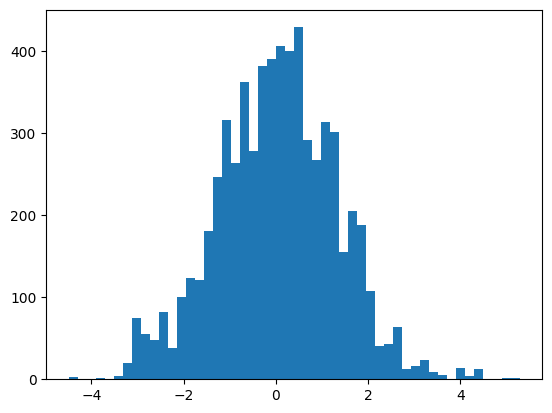

In [51]:
plt.hist(hpreact.view(-1).tolist(), bins=50)

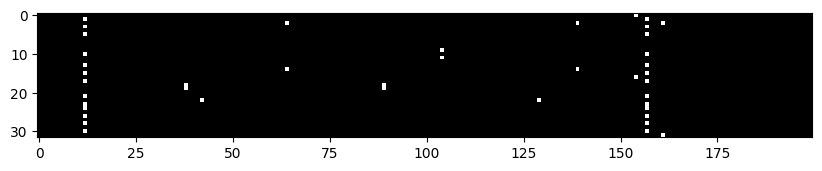

In [55]:
plt.figure(figsize=(10, 5))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

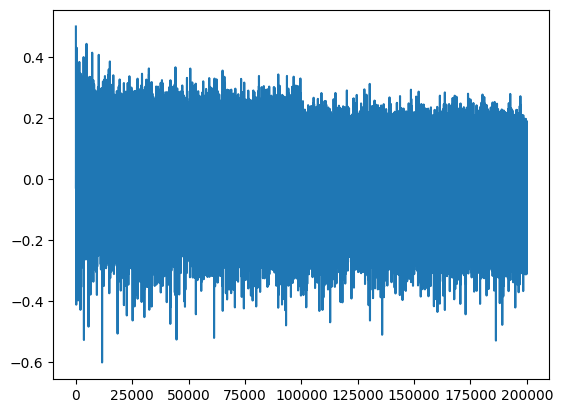

In [35]:
plt.plot(lossi)

In [67]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [71]:
@torch.no_grad() # disable gradient descent
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # bnmeani = hpreact.mean(0, keepdim=True)
    # bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running - bnbias
    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
split_loss('train')
split_loss('val')

train 1.0074577331542969
val 1.1806522607803345


# initial net
train 1.000532865524292
val 1.394815444946289

# after dampening the W2 and b2 (fix softmax confidently wrong)
train 1.0001459121704102
val 1.2435673475265503

# after dampening W1 and B1 (fix tanh saturation)
train 1.000976800918579
val 1.2172609567642212

# after using the kaiming init 
train 1.0001680850982666
val 1.2211095094680786

# with batchnorm layer
train 1.0072804689407349
val 1.1897488832473755

# with batchnorm and calibrated bnmean and bnstd
train 1.0072836875915527
val 1.1784292459487915

# with batchnorm and running bnmean and bnstd
train 1.0074577331542969
val 1.1806522607803345

In [22]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range (20):
    out = [] 
    context = [0] * 3
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, 1)
        ix = torch.multinomial(probs, 1, generator=g).item()
        out.append(ix)
        context = context[1:] + [ix]
        if itos[out[-1]] == '<E>':
            break
    print(' '.join(itos[i] for i in out))

2.0 1.0 2.0 2.0 1.0 <E>
1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 4.0 1.0 2.0 2.0 2.0 1.0 1.0 1.0 2.0 1.0 1.0 1.0 1.0 1.0 <E>
1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 <E>
4.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0 1.0 1.0 0.0 <M> <E>
1.0 1.0 1.0 2.0 2.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 <E>
1.0 1.0 1.0 1.0 1.0 1.0 2.0 3.0 1.0 1.0 <E>
1.0 1.0 1.0 <E>
0.0 1.0 2.0 1.0 <M> <M> 2.0 <M> 2.0 8.0 <M> 1.0 <E>
1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 4.0 1.0 2.0 1.0 1.0 <E>
1.0 1.0 1.0 1.0 1.0 1.0 2.0 1.0 1.0 3.0 5.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 <E>
1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 2.0 5.0 2.0 2.0 3.0 2.0 4.0 1.0 1.0 1.0 1.0 3.0 2.0 1.0 1.0 2.0 4.0 5.0 1.0 2.0 3.0 3.0 3.0 2.0 1.0 1.0 1.0 3.0 4.0 2.0 4.0 3.0 6.0 1.0 1.0 1.0 <E>
1.0 1.0 1.0 1.0 1.0 2.0 2.0 1.0 1.0 1.0 2.0 1.0 1.0 <E>
1.0 1.0 1.0 1.0 1.0 1.0 2.0 1.0 2.0 2.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 <E>
0.0 0.0 2.0 1.0 1.0 1.0 2.0 2.0 1.0 1.0 1.0 <E>
1.0 1.0 2.0 1.0 1.0 1.0 <E>
1.0 1.0 

In [24]:
# at initialisation we would expect probability would be around
-torch.tensor(1/24).log()

tensor(3.1781)

In [61]:
import torch.nn as nn

In [66]:
test = nn.BatchNorm1d(3)
test.weight.data *= 0.1
test.weight

Parameter containing:
tensor([0.1000, 0.1000, 0.1000], requires_grad=True)

In [76]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])
  

class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []
  
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
# layers = [
#   nn.Linear(n_embd * block_size, n_hidden, bias=False), nn.BatchNorm1d(n_hidden), nn.Tanh(),
#   nn.Linear(           n_hidden, n_hidden, bias=False), nn.BatchNorm1d(n_hidden), nn.Tanh(),
#   nn.Linear(           n_hidden, n_hidden, bias=False), nn.BatchNorm1d(n_hidden), nn.Tanh(),
#   nn.Linear(           n_hidden, n_hidden, bias=False), nn.BatchNorm1d(n_hidden), nn.Tanh(),
#   nn.Linear(           n_hidden, n_hidden, bias=False), nn.BatchNorm1d(n_hidden), nn.Tanh(),
#   nn.Linear(           n_hidden, vocab_size, bias=False), nn.BatchNorm1d(vocab_size),
# ]
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  # layers[-1].weight.data *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

46688


In [77]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    outputs = [] # store the output of each layer, required if using torch.nn layers
    for layer in layers:
        x = layer(x)
        outputs.append(x)
    loss = F.cross_entropy(x, Yb) # loss function
    
    # backward pass
    # for layer in layers:
    #     layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    # for output in outputs:
    #     output.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    # with torch.no_grad():
    #     ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    # if i >= 1000:
    #     break # AFTER_DEBUG: would take out obviously to run full optimization


      0/ 200000: 3.1714
  10000/ 200000: 1.3111
  20000/ 200000: 1.1504
  30000/ 200000: 1.2124
  40000/ 200000: 0.7580
  50000/ 200000: 0.8331
  60000/ 200000: 1.1760
  70000/ 200000: 0.8071
  80000/ 200000: 1.0350
  90000/ 200000: 1.3482
 100000/ 200000: 1.3317
 110000/ 200000: 1.1131
 120000/ 200000: 0.7798
 130000/ 200000: 1.0537
 140000/ 200000: 1.2596
 150000/ 200000: 1.0556
 160000/ 200000: 0.9075
 170000/ 200000: 1.4329
 180000/ 200000: 0.9255
 190000/ 200000: 0.9752


In [78]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 0.9964696168899536
val 1.2565152645111084


## using torch.nn layers
So using the torch.nn layers, it took about 5 1/2 mins to go through 200000 iterations. we get a val loss of 1.25. This is much better than the mlp, which was around 1.75. So that's a big improvement.
## with karpathy's implementation
it was much quicker, 4 3/4 minutes. and quite similarly lossy, at around 1.26.

In [79]:
print("CUDA Available: ", torch.cuda.is_available())
print("Number of GPUs: ", torch.cuda.device_count())

CUDA Available:  False
Number of GPUs:  0


test


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 3.16%
layer 5 (      Tanh): mean -0.00, std 0.65, saturated: 2.06%
layer 8 (      Tanh): mean +0.00, std 0.65, saturated: 1.97%
layer 11 (      Tanh): mean +0.00, std 0.66, saturated: 0.91%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.09%


Text(0.5, 1.0, 'activation distribution')

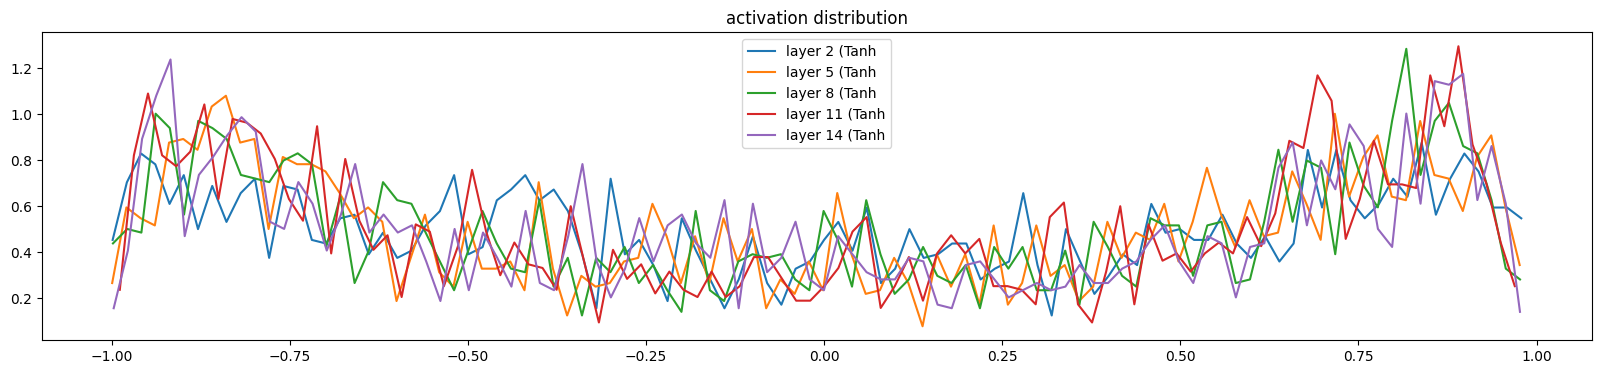

In [56]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 2.521902e-03
layer 5 (      Tanh): mean -0.000000, std 2.009388e-03
layer 8 (      Tanh): mean +0.000000, std 1.777886e-03
layer 11 (      Tanh): mean -0.000000, std 1.721793e-03
layer 14 (      Tanh): mean +0.000000, std 1.795491e-03


Text(0.5, 1.0, 'gradient distribution')

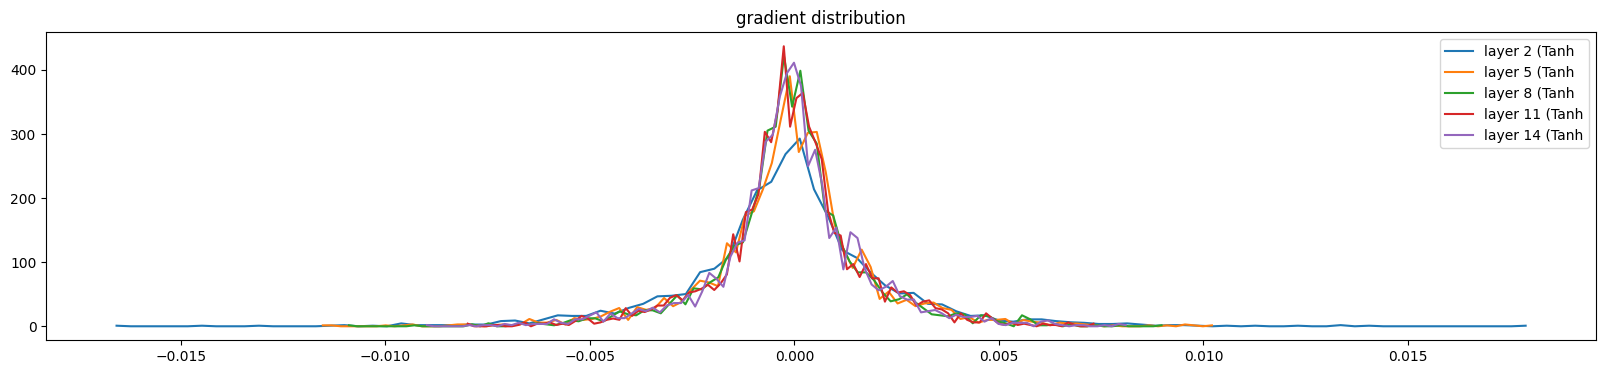

In [57]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (24, 10) | mean -0.000000 | std 4.560305e-03 | grad:data ratio 4.418080e-03
weight  (100, 30) | mean +0.000019 | std 6.686864e-03 | grad:data ratio 6.094962e-02
weight (100, 100) | mean +0.000008 | std 3.985375e-03 | grad:data ratio 6.618822e-02
weight (100, 100) | mean -0.000016 | std 3.793002e-03 | grad:data ratio 6.381690e-02
weight (100, 100) | mean -0.000046 | std 3.902781e-03 | grad:data ratio 6.502828e-02
weight (100, 100) | mean -0.000046 | std 4.420185e-03 | grad:data ratio 7.443429e-02
weight  (24, 100) | mean +0.000064 | std 1.084802e-02 | grad:data ratio 1.669900e-01


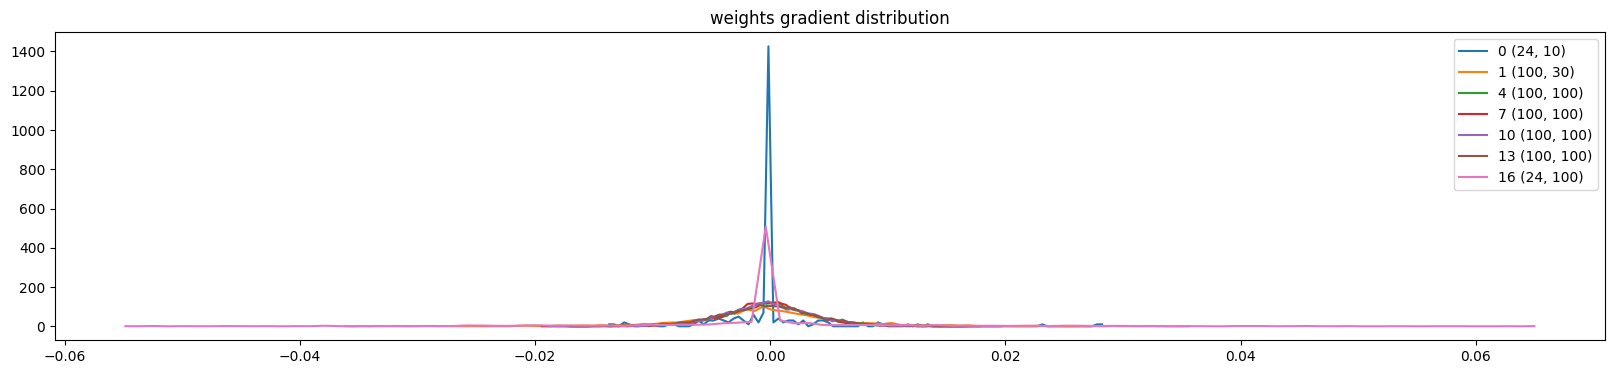

In [71]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

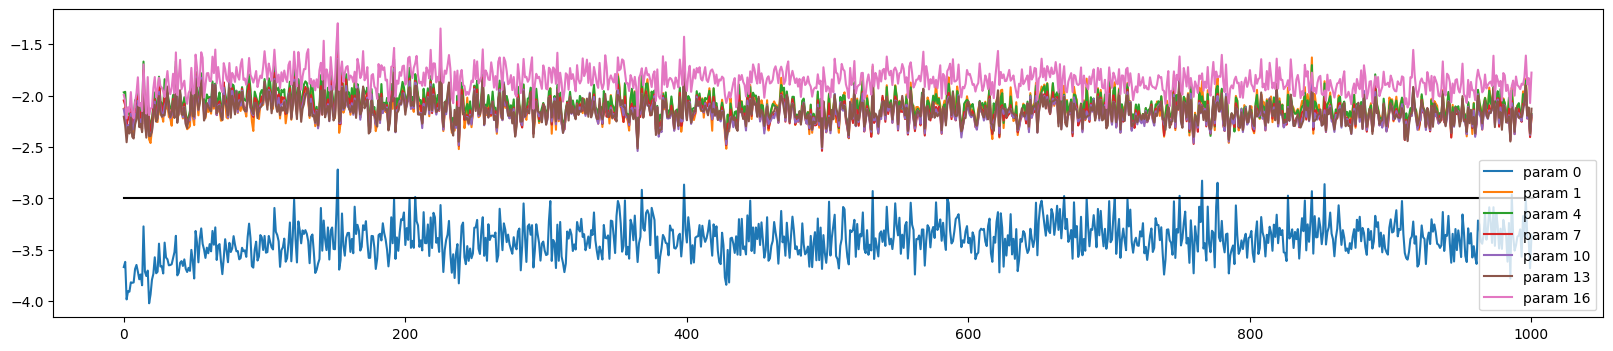

In [72]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

Great, so in this lecture, the point was to introduce batchnorm layers, and show how they make initialisation deep neural networks much easier to do, and hence enable them to be optimised. Next, we worked with some of the diagnostic tools used to check that the net is well initialised, and that it is learning (updating gradients) during backpropagation at an a appropriate rate. Finally, we worked with modules that are very similar or even identical to those used in pytorch.